**This notebook has been prepared by Pr Fabien Moutarde and Dr Guillaume Devineau from the Center for Robotics of MINES Paris PSL.**

It adapts/combines 2 notebooks from : http://online.cambridgecoding.com/notebooks/cca_admin/deep-learning-for-complete-beginners-recognising-handwritten-digits
http://online.cambridgecoding.com/notebooks/cca_admin/convolutional-neural-networks-with-keras

**NOTE: If you try to execute this notebook on Google COLAB (https://colab.research.google.com/notebooks/welcome.ipynb)**, you should: 1/ make sure that you are using python3 and a *GPU accelerated backend* (select *GPU* as Hardware accelerator either in the *Edit > Notebook settings* or in the *Runtime > Change runtime type* menus for the english colab interface, or in the *Execution > Modifier le type d'exécution* menus for the french colab interface); 2/ modify the Force_CPU to False in one of the first code block

# Deep-Learning: Introduction to Convolutional Neural Networks

## 1. Introduction

Welcome to a tutorial to get you quickly up to speed with *deep learning*; from first principles, all the way to discussions of some of the intricate details, with the purposes of achieving respectable performance on one established machine learning benchmark: [MNIST](http://yann.lecun.com/exdb/mnist/) (classification of handwritten digits).


MNIST dataset                      
![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/mnist.png)  

By the end of this part of the tutorial, you should be capable of understanding and producing a simple CNN (with a structure similar to LeNet architecture) in Keras, achieving a respectable level of accuracy on MNIST.


## 2. Convolutions

It turns out that there is a very efficient way of pulling this off, and it makes advantage of the structure of the information encoded within an image---it is assumed that pixels that are spatially *closer* together will "cooperate" on forming a particular feature of interest much more than ones on opposite corners of the image. Also, if a particular (smaller) feature is found to be of great importance when defining an image's label, it will be equally important if this feature was found anywhere within the image, regardless of location.

Enter the **convolution** operator. Given a two-dimensional image, $\bf I$, and a small matrix, $\bf K$ of size $h \times w$, (known as a *convolution kernel*), which we assume encodes a way of extracting an interesting image feature, we compute the convolved image, ${\bf I} * {\bf K}$, by overlaying the kernel on top of the image in all possible ways, and recording the sum of elementwise products between the image and the kernel:

$$({\bf I} * {\bf K})_{xy} = \sum_{i=1}^h \sum_{j=1}^w {{\bf K}_{ij} \cdot {\bf I}_{x + i - 1, y + j - 1}}$$

(in fact, the exact definition would require us to flip the kernel matrix first, but for the purposes of machine learning it is irrelevant whether this is done)

The images below show a diagrammatical overview of the above formula and the result of applying convolution (with two separate kernels) over an image, to act as an edge detector:

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/convolve.png)
![](http://people.minesparis.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/lena.jpg)

## 3. Convolutional layers and Pooling layers

The convolution operator forms the fundamental basis of the **convolutional** layer of a CNN. The layer is completely specified by a certain number of kernels, $\bf \vec{K}$ (along with additive biases, $\vec{b}$, per each kernel), and it operates by computing the convolution of the output images of a previous layer with each of those kernels, afterwards adding the biases (one per each output image). Finally, an activation function, $\sigma$, may be applied to all of the pixels of the output images. Typically, the input to a convolutional layer will have $d$ *channels* (e.g. red/green/blue in the input layer), in which case the kernels are extended to have this number of channels as well, making the final formula of a single output image channel of a convolutional layer (for a kernel ${\bf K}$ and bias $b$) as follows:

$$\mathrm{conv}({\bf I}, {\bf K})_{xy} = \sigma\left(b + \sum_{i=1}^h \sum_{j=1}^w \sum_{k=1}^d {{\bf K}_{ijk} \cdot {\bf I}_{x + i - 1, y + j - 1, k}}\right)$$

Note that, since all we're doing here is addition and scaling of the input pixels, the kernels may be learned from a given training dataset via *gradient descent*, exactly as the weights of an MLP. In fact, an MLP is perfectly capable of replicating a convolutional layer, but it would require a lot more training time (and data) to learn to approximate that mode of operation.

Finally, let's just note that a convolutional operator is in no way restricted to two-dimensionally structured data: in fact, most machine learning frameworks ([Keras included](https://keras.io/layers/convolutional/)) will provide you with out-of-the-box layers for 1D and 3D convolutions as well!

It is important to note that, while a convolutional layer significantly decreases the number of *parameters* compared to a fully connected (FC) layer, it introduces more **hyperparameters**---parameters whose values need to be chosen *before* training starts.

Namely, the hyperparameters to choose within a single convolutional layer are:
- *depth*: how many different kernels (and biases) will be convolved with the output of the previous layer;
- *height* and *width* of each kernel;
- *stride*: by how much we shift the kernel in each step to compute the next pixel in the result. This specifies the overlap between individual output pixels, and typically it is set to $1$, corresponding to the formula given before. Note that larger strides result in smaller output sizes.
- *padding*: note that convolution by any kernel larger than $1\times 1$ will *decrease* the output image size---it is often desirable to keep sizes the same, in which case the image is sufficiently padded with zeroes at the edges. This is often called *"same"* padding, as opposed to *"valid"* (no) padding. It is possible to add arbitrary levels of padding, but typically the padding of choice will be either same or valid.

As already hinted, convolutions are not typically meant to be the sole operation in a CNN (although there have been promising recent developments on [all-convolutional networks](https://arxiv.org/pdf/1412.6806v3.pdf)); but rather to extract useful features of an image prior to downsampling it sufficiently to be manageable by an MLP.

A very popular approach to downsampling is a *pooling* layer, which consumes small and (usually) disjoint chunks of the image (typically $2\times 2$) and aggregates them into a single value. There are several possible schemes for the aggregation---the most popular being **max-pooling**, where the maximum pixel value within each chunk is taken. A diagrammatical illustration of $2\times 2$ max-pooling is given below.

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/pool.png)

## 4. Convolutional Neural Network (CNN) architecture

Now that we got all the building blocks, let's see what a typical convolutional neural network might look like!

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/cnn.png)

A typical CNN architecture for a $k$-class image classification can be split into two distinct parts---a chain of repeating $\mathrm{Conv}\rightarrow\mathrm{Pool}$ layers (sometimes with more than one convolutional layer at once), followed by a few fully connected layers (taking each pixel of the computed images as an independent input), culminating in a $k$-way softmax layer, to which a cross-entropy loss is optimised. I did not draw the activation functions here to make the sketch clearer, but do keep in mind that typically after every convolutional or fully connected layer, an activation (e.g. ReLU) will be applied to all of the outputs.

Note the effect of a single $\mathrm{Conv}\rightarrow\mathrm{Pool}$ pass through the image: it reduces height and width of the individual channels in favour of their number, i.e. *depth*.

The softmax layer and cross-entropy loss are both introduced in more detail [in the previous tutorial](http://online.cambridgecoding.com/notebooks/cca_admin/deep-learning-for-complete-beginners-recognising-handwritten-digits). For summarisation purposes, a softmax layer's purpose is converting any vector of real numbers into a vector of *probabilities* (nonnegative real values that add up to 1). Within this context, the probabilities correspond to the likelihoods that an input image is a member of a particular class. Minimising the cross-entropy loss has the effect of maximising the model's confidence in the *correct* class, without being concerned for the probabilites for other classes---this makes it a more suitable choice for probabilistic tasks compared to, for example, the squared error loss.

## 5. Detour: Overfitting, regularisation and dropout

This will be the first (and hopefully the only) time when I will divert your attention to a seemingly unrelated topic. It regards a very important pitfall of machine learning---**overfitting** a model to the training data. While this is primarily going to be a major topic of the next tutorial in the series, the negative effects of overfitting will tend to become quite noticeable on the networks like the one we are about to build, and we need to introduce a way to properly protect ourselves against it, before going any further. Luckily, there is a very simple technique we can use.

Overfitting corresponds to adapting our model to the training set to such extremes that its generalisation potential (performance on samples outside of the training set) is *severely* limited. In other words, our model might have learned the training set (along with any noise present within it) perfectly, but it has failed to capture the underlying process that generated it. To illustrate, consider a problem of fitting a sine curve, with white additive noise applied to the data points:

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/plotsin.png)

Here we have a training set (denoted by blue circles) derived from the original sine wave, along with some noise. If we fit a degree-3 polynomial to this data, we get a fairly good approximation to the original curve. Someone might argue that a degree-14 polynomial would do better; indeed, given we have 15 points, such a fit would *perfectly* describe the training data. However, in this case, the additional parameters of the model cause catastrophic results: to cope with the inherent noise of the data, anywhere except in the closest vicinity of the training points, our fit is completely off.

Deep convolutional neural networks have a large number of parameters, especially in the fully connected layers. Overfitting might often manifest in the following form: if we don't have sufficiently many training examples, a small group of neurons might become responsible for doing most of the processing and other neurons becoming redundant; or in the other extreme, some neurons might actually become detrimental to performance, with several other neurons of their layer ending up doing nothing else but correcting for their errors.

To help our models generalise better in these circumstances, we introduce techniques of *regularisation*: rather than reducing the number of parameters, we impose *constraints* on the model parameters during training to keep them from learning the noise in the training data. The particular method I will introduce here is **dropout**---a technique that initially might seem like "dark magic", but actually helps to eliminate exactly the failure modes described above. Namely, dropout with parameter $p$ will, within a single training iteration, go through all neurons in a particular layer and, with probability $p$, *completely eliminate them from the network throughout the iteration*. This has the effect of forcing the neural network to cope with *failures*, and not to rely on existence of a particular neuron (or set of neurons)---relying more on a *consensus* of several neurons within a layer. This is a very simple technique that works quite well already for combatting overfitting on its own, without introducing further regularisers. An illustration is given below.

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/drop.png)

## 6. Applying a deep CNN to MNIST

As this post's objective, we will implement a deep convolutional neural network---and apply it on the MNIST digit recognition classification task.


As already mentioned, a CNN will typically have more hyperparameters than an MLP. For the purposes of this tutorial, we will also stick to "sensible" hand-picked values for them, but do still keep in mind that later on I will introduce a more proper method for learning them.

The hyperparameters are:
- The *batch size*, representing the number of training examples being used simultaneously during a single iteration of the gradient descent algorithm;
- The number of *epochs*, representing the number of times the training algorithm will iterate over the entire training set before terminating\*;
- The *kernel sizes* in the convolutional layers;
- The *pooling size* in the pooling layers;
- The *number of kernels* in the convolutional layers;
- The *dropout probability* (we will apply dropout after each pooling, and after the fully connected layer);
- The *number of neurons* in the fully connected layer of the MLP.

\* **N.B. here I have set the number of epochs to 100, which might be undesirably slow if you do not have a GPU at your disposal (the convolution layers are going to pose a significant performance bottleneck in this case). You might wish to decrease the epoch count and/or numbers of kernels if you are going to be training the network on a CPU.**


Modelling time! Our network has an architecture similar to LeNet5 of LeCun (see figure below). It will consist of two consecutive groups of one `Convolution2D` followed by  a `MaxPooling2D` layer. After the first pooling layer, the number of kernels is rougly doubled (in line with the previously mentioned principle of sacrificing height and width for more depth). Afterwards, the output of the second pooling layer is flattened to 1D (via the `Flatten` layer), and passed through one or two fully connected (`Dense`) layers. ReLU activations will once again be used for all layers except the output dense layer, which will use a softmax activation (for purposes of probabilistic classification).

![](http://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/TP_convNets/lenet5.png)

To regularise our model, a `Dropout` layer is applied after each pooling layer, and after the first `Dense` layer. This is another area where Keras shines compared to other frameworks: it has an internal flag that automatically enables or disables dropout, depending on whether the model is currently used for training or testing.

The remainder of the model specification is the following:
- We use the *cross-entropy* loss function as the objective to optimise (as its derivation is more appropriate for probabilistic tasks);
- We use the [*Adam* optimiser for gradient descent](http://sebastianruder.com/optimizing-gradient-descent/);
- We report the *accuracy* of the model (as the dataset is balanced across the ten classes)\*;
- We hold out 10% of the data for validation purposes.

\* To get a feeling for why accuracy might be inappropriate for unbalanced datasets, consider an extreme case where 90% of the test data belongs to class $x$ (this could be, for example, the task of diagnosing patients for an extremely rare disease). In this case, a classifier that just outputs $x$ achieves a seemingly impressive accuracy of 90% on the test data, without really doing any learning/generalisation.

This model, possibly after some tweaking of its architectural parameters, should be able to break $99\%$ accuracy on its **test set** with little to no effort.


## 7. Conclusion

Throughout this post we have covered the essentials of convolutional neural networks, introduced the problem of overfitting, and made a very brief dent into how it could be rectified via regularisation (by applying dropout) and successfully implemented a two-layer deep CNN (with LeNet like architecture) in Keras, applying it to MNIST, all in under 50 lines of code.


## 8. Just show me the code!

This code assume your already have installed <code>numpy</code>, <code>keras</code>, <code>tensorflow</code>, ... on your computer. If not, uncomment the adequate lines in the cell below:

In [6]:
import sys
print('Your python version: {}'.format(sys.version_info.major))
# Uncomment lines below only if you need them
#!{sys.executable} -m pip install -U numpy --user
#!{sys.executable} -m pip install -U matplotlib --user
#
#!{sys.executable} -m pip install -U tensorflow --user
# OR (if in China, for faster download)
#!{sys.executable} -m pip install -U tensorflow --user -i https://pypi.tuna.tsinghua.edu.cn/simple

Your python version: 3


In [7]:

import tensorflow
print('Your tensorflow version: {}'.format(tensorflow.__version__))
print("GPU : "+tensorflow.test.gpu_device_name())


Your tensorflow version: 2.19.0
GPU : /device:GPU:0


In [8]:
import numpy as np
from tensorflow.keras.datasets import mnist # subroutines for fetching the MNIST dataset
# --------------------------------------
# Dataset variables
# --------------------------------------
num_train = 60000 # there are 60000 training examples in MNIST
num_test = 10000  # there are 10000 test examples in MNIST
height, width, depth = 28, 28, 1 # MNIST images are 28x28 with 1 channel (greyscale)
num_classes = 10                 # there are 10 classes (1 per digit)

# --------------------------------------
# Dataset loading & preprocessing
# --------------------------------------
(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255 # Normalise data to [0, 1] range
X_test /= 255 # Normalise data to [0, 1] range

X_train = X_train[:, :, :, np.newaxis] # Reshape in "convolutionable" format (add tensor dim for the depth)
X_test = X_test[:, :, :, np.newaxis] # Reshape in "convolutionable" format (add tensor dim for the depth)

# One-hot encode the labels
Y_train = np.eye(num_classes)[y_train]
Y_test = np.eye(num_classes)[y_test]

print(X_train.shape, Y_train.shape)

(60000, 28, 28, 1) (60000, 10)


In [9]:

import tensorflow.keras
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist # subroutines for fetching the MNIST dataset
from tensorflow.keras.models import Model, Sequential # basic class for specifying and training a neural network
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
# --------------------------------------
# Network params
# --------------------------------------
# Network params
batch_size = 32    # in each iteration, we consider 32 training examples at once
num_epochs = 11    # we iterate num_epochs times over the entire training set
kernel_size = 5    # we will use 5x5 kernels throughout
pool_size = 2      # we will use 2x2 pooling throughout
conv_depth_1 = 6   # we will initially have 6 kernels in first conv. layer...
conv_depth_2 = 16  # ...switching to 16 after the first pooling layer
drop_prob_1 = 0.   # dropout after pooling with probability 0.
drop_prob_2 = 0.   # dropout in the FC layer with probability 0.
hidden_size = 30  # the FC layer before output will have hidden_size neurons
weight_penalty = 0. # Factor for weights penalty

# --------------------------------------
# CNN network definition
# --------------------------------------
# inp = Input(shape=(1,height,width)) # greyscale --> depth==1
# model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

model = Sequential()
# Conv [8] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu', data_format="channels_last", input_shape=( 28, 28, 1)) )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) )

# Conv [16] -> Pool (with dropout on the pooling layer)
model.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu') )
model.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model.add( Dropout(drop_prob_1) )

# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
model.add( Flatten() )
model.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model.add( Dropout(drop_prob_2) )
model.add( Dense(num_classes, activation='softmax') )

print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,432 (103.25 KB)

 Trainable params: 26,432 (103.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# --------------------------------------
# Loss function and Optimizer
# --------------------------------------
model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

# --------------------------------------
# Training
# --------------------------------------
history = model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.7) # ...holding out 70% of the data for validation

# --------------------------------------
# Evaluation
# --------------------------------------
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.3f}.'.format(loss_name, loss_value)) # Evaluate the trained model on the test set!

Epoch 1/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7389 - loss: 0.8370 - val_accuracy: 0.9471 - val_loss: 0.1762
Epoch 2/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9562 - loss: 0.1469 - val_accuracy: 0.9620 - val_loss: 0.1179
Epoch 3/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9721 - loss: 0.0903 - val_accuracy: 0.9720 - val_loss: 0.0918
Epoch 4/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9772 - loss: 0.0767 - val_accuracy: 0.9737 - val_loss: 0.0869
Epoch 5/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9826 - loss: 0.0567 - val_accuracy: 0.9756 - val_loss: 0.0780
Epoch 6/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9842 - loss: 0.0526 - val_accuracy: 0.9757 - val_loss: 0.0825
Epoch 7/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9863 - loss: 0.0424 - val_accuracy: 0.9789 - val_loss: 0.0715
Epoch 8/11
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9888 - loss: 0.0322 - val_accuracy: 

**Plot the training history, in order to check if overfitting seems to have occured or not, and if more training epochs could be performed.**


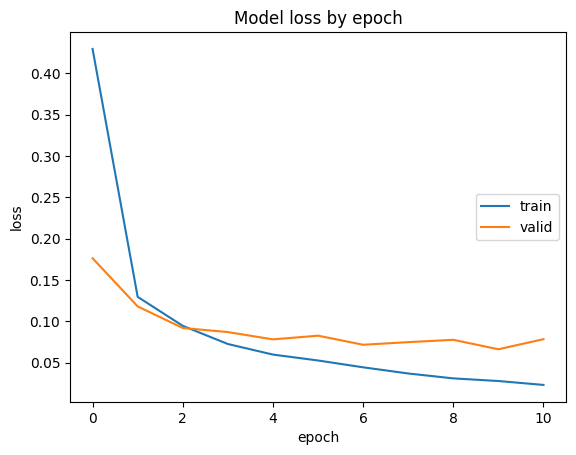

In [11]:
import matplotlib.pyplot as plt
# --------------------------------------
# Loss functions evolution
# --------------------------------------
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()



**You should see that over-fitting begins to occur.**
 - **Question 1: WHAT IS THE SIGN OF OVER-FITTING ON ABOVE GRAPH?**

 - **Answer:** *The sign of overfitting on the graph is when the validation loss starts to increase while the training loss continues to decrease. This divergence indicates that the model is memorizing the training data rather than learning generalizable patterns. The gap between training and validation loss curves becomes wider, showing that the model performs well on training data but poorly on unseen validation data.*

**Question 2: Search into [Keras documentation](https://keras.io/api/) how to enforce early-stopping, implement the slight modification in code-cell below, re-run and observe result. At which iteration does training stop now?**


Epoch 1/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9946 - loss: 0.0186 - val_accuracy: 0.9797 - val_loss: 0.0788
Epoch 2/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9951 - loss: 0.0159 - val_accuracy: 0.9798 - val_loss: 0.0795
Epoch 3/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9956 - loss: 0.0135 - val_accuracy: 0.9798 - val_loss: 0.0778
Epoch 4/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9955 - loss: 0.0125 - val_accuracy: 0.9815 - val_loss: 0.0764
Epoch 5/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9961 - loss: 0.0125 - val_accuracy: 0.9787 - val_loss: 0.0943
Epoch 6/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9947 - loss: 0.0142 - val_accuracy: 0.9796 - val_loss: 0.0890
Epoch 7/50
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9978 - loss: 0.0069 - val_accuracy: 0.9819 - val_loss: 0.0807


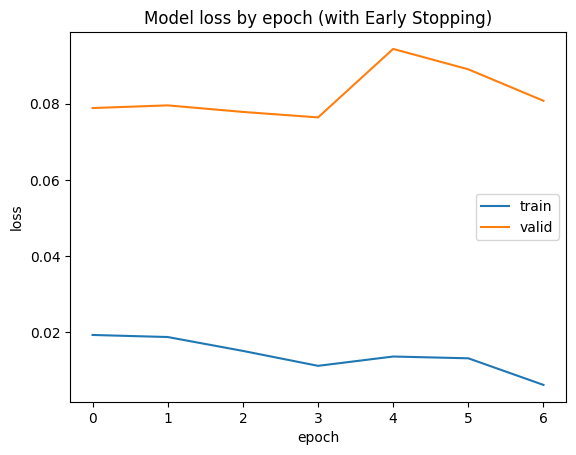


Training stopped at epoch: 7
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9823 - loss: 0.0649
The final loss on the TEST set is: 0.055.
The final compile_metrics on the TEST set is: 0.985.


In [12]:
# Paste here code for training modified to enforce early-stopping, + visualize new training curves

from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=3,              # Stop if no improvement for 3 epochs
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

# Train the model with early stopping
history_early_stop = model.fit(X_train, Y_train,
                               batch_size=batch_size,
                               epochs=50,  # Set a large number, early stopping will stop earlier
                               verbose=1,
                               validation_split=0.7,
                               callbacks=[early_stopping])

# Visualize training curves
plt.plot(history_early_stop.history['loss'])
plt.plot(history_early_stop.history['val_loss'])
plt.title('Model loss by epoch (with Early Stopping)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

print(f'\nTraining stopped at epoch: {len(history_early_stop.history["loss"])}')

# Evaluate on test set
for loss_name, loss_value in list(zip(model.metrics_names, model.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.3f}.'.format(loss_name, loss_value))


**In order to obtain better training result, *you need to be able to train during more iterations before over-fitting starts to occur*. It is therefore needed not only to detect overfitting for stopping, but to also use some method that can MITIGATE overfitting so that it does NOT occur, or at least after many more iterations.**

 - **Question 3: what are the 2 different methods that can be used to PREVENT over-fitting ?**
 - **Answer:** *The two main regularization methods to prevent overfitting are:*
   1. *Dropout: This technique randomly deactivates a proportion of neurons during training (with probability p). It forces the network to learn redundant representations and prevents co-adaptation of neurons, making the model more robust and less likely to overfit.*
   2. *Weight regularization (L2 regularization or weight decay): This adds a penalty term to the loss function proportional to the magnitude of the weights. It discourages large weight values, leading to simpler models that generalize better by preventing the network from fitting noise in the training data.*

**Test those 2 methods SEPARATELY below, by copy-pasting the original code, modifying it, and running it.**

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,432 (103.25 KB)

 Trainable params: 26,432 (103.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4493 - loss: 1.5530 - val_accuracy: 0.9348 - val_loss: 0.2683
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8199 - loss: 0.5595 - val_accuracy: 0.9578 - val_loss: 0.1508
Epoch 3/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8760 - loss: 0.3951 - val_accuracy: 0.9639 - val_loss: 0.1239
Epoch 4/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8910 - loss: 0.3406 - val_accuracy: 0.9690 - val_loss: 0.1060
Epoch 5/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9074 - loss: 0.2942 - val_accuracy: 0.9689 - val_loss: 0.1009
Epoch 6/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9162 - loss: 0.2640 - val_accuracy: 0.9736 - val_loss: 0.0875
Epoch 7/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9156 - loss: 0.2579 - val_accuracy: 0.9752 - val_loss: 0.0812
Epoch 8/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9218 - loss: 0.2468 - val_accur

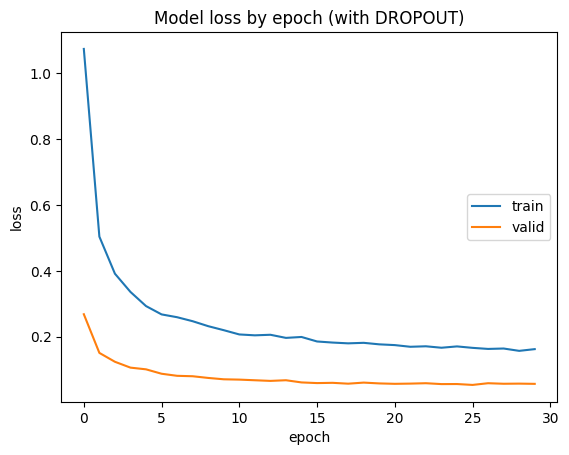

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9815 - loss: 0.0539
The final loss on the TEST set is: 0.047.
The final compile_metrics on the TEST set is: 0.985.


In [13]:
# Test ConvNet overfitting prevention method #1: DROPOUT

import tensorflow.keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

# Network params with DROPOUT enabled
batch_size = 32
num_epochs = 30
kernel_size = 5
pool_size = 2
conv_depth_1 = 6
conv_depth_2 = 16
drop_prob_1 = 0.25  # DROPOUT after pooling
drop_prob_2 = 0.5   # DROPOUT in the FC layer
hidden_size = 30
weight_penalty = 0.  # No L2 regularization for this test

# Build model with dropout
model_dropout = Sequential()
model_dropout.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu', data_format="channels_last", input_shape=( 28, 28, 1)) )
model_dropout.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model_dropout.add( Dropout(drop_prob_1) )  # Dropout enabled

model_dropout.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu') )
model_dropout.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model_dropout.add( Dropout(drop_prob_1) )  # Dropout enabled

model_dropout.add( Flatten() )
model_dropout.add( Dense(hidden_size, activation='relu', kernel_regularizer=regularizers.l2(weight_penalty)) )
model_dropout.add( Dropout(drop_prob_2) )  # Dropout enabled
model_dropout.add( Dense(num_classes, activation='softmax') )

print(model_dropout.summary())

# Compile and train
model_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_dropout = model_dropout.fit(X_train, Y_train,
                                    batch_size=batch_size,
                                    epochs=num_epochs,
                                    verbose=1,
                                    validation_split=0.7)

# Visualize training curves
plt.plot(history_dropout.history['loss'])
plt.plot(history_dropout.history['val_loss'])
plt.title('Model loss by epoch (with DROPOUT)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

# Evaluate on test set
for loss_name, loss_value in list(zip(model_dropout.metrics_names, model_dropout.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.3f}.'.format(loss_name, loss_value))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 30)             │        23,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,432 (103.25 KB)

 Trainable params: 26,432 (103.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7180 - loss: 0.9326 - val_accuracy: 0.9517 - val_loss: 0.2309
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9528 - loss: 0.2243 - val_accuracy: 0.9663 - val_loss: 0.1771
Epoch 3/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9681 - loss: 0.1682 - val_accuracy: 0.9679 - val_loss: 0.1683
Epoch 4/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9737 - loss: 0.1509 - val_accuracy: 0.9744 - val_loss: 0.1467
Epoch 5/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9783 - loss: 0.1322 - val_accuracy: 0.9764 - val_loss: 0.1407
Epoch 6/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9825 - loss: 0.1179 - val_accuracy: 0.9749 - val_loss: 0.1388
Epoch 7/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9835 - loss: 0.1124 - val_accuracy: 0.9763 - val_loss: 0.1338
Epoch 8/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9848 - loss: 0.1088 - val_accur

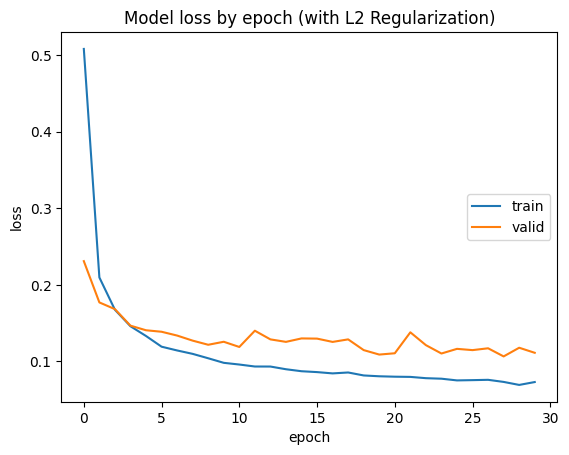

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9767 - loss: 0.1139
The final loss on the TEST set is: 0.101.
The final compile_metrics on the TEST set is: 0.982.


In [14]:
# Test ConvNet overfitting prevention method #2: L2 WEIGHT REGULARIZATION

import tensorflow.keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

# Network params with L2 regularization enabled
batch_size = 32
num_epochs = 30
kernel_size = 5
pool_size = 2
conv_depth_1 = 6
conv_depth_2 = 16
drop_prob_1 = 0.  # No dropout for this test
drop_prob_2 = 0.  # No dropout for this test
hidden_size = 30
weight_penalty = 0.001  # L2 REGULARIZATION enabled

# Build model with L2 regularization
model_l2 = Sequential()
model_l2.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu',
                     data_format="channels_last", input_shape=( 28, 28, 1),
                     kernel_regularizer=regularizers.l2(weight_penalty)) )
model_l2.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model_l2.add( Dropout(drop_prob_1) )

model_l2.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu',
                     kernel_regularizer=regularizers.l2(weight_penalty)) )
model_l2.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model_l2.add( Dropout(drop_prob_1) )

model_l2.add( Flatten() )
model_l2.add( Dense(hidden_size, activation='relu',
                    kernel_regularizer=regularizers.l2(weight_penalty)) )  # L2 regularization
model_l2.add( Dropout(drop_prob_2) )
model_l2.add( Dense(num_classes, activation='softmax') )

print(model_l2.summary())

# Compile and train
model_l2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_l2 = model_l2.fit(X_train, Y_train,
                          batch_size=batch_size,
                          epochs=num_epochs,
                          verbose=1,
                          validation_split=0.7)

# Visualize training curves
plt.plot(history_l2.history['loss'])
plt.plot(history_l2.history['val_loss'])
plt.title('Model loss by epoch (with L2 Regularization)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

# Evaluate on test set
for loss_name, loss_value in list(zip(model_l2.metrics_names, model_l2.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.3f}.'.format(loss_name, loss_value))


**FINAL ASSIGNMENT:**
**In code cell below, by applying a good combination and parameterization of the 2 regularization techniques, + increasing the number of training epochs, + reducing the proportion of validation hold-out, TRY TO OBTAIN >99% acuracy ON TEST SET:**

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,922 (1.74 MB)

 Trainable params: 454,922 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8422 - loss: 0.5192 - val_accuracy: 0.9847 - val_loss: 0.0997
Epoch 2/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9706 - loss: 0.1479 - val_accuracy: 0.9897 - val_loss: 0.0962
Epoch 3/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9787 - loss: 0.1333 - val_accuracy: 0.9912 - val_loss: 0.0933
Epoch 4/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9816 - loss: 0.1247 - val_accuracy: 0.9913 - val_loss: 0.0926
Epoch 5/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9829 - loss: 0.1244 - val_accuracy: 0.9903 - val_loss: 0.0968
Epoch 6/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9831 - loss: 0.1241 - val_accuracy: 0.9913 - val_loss: 0.0964
Epoch 7/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9840 - loss: 0.1151 - val_accuracy: 0.9910 - val_loss: 0.0953
Epoch 8/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9846 - loss: 0.1

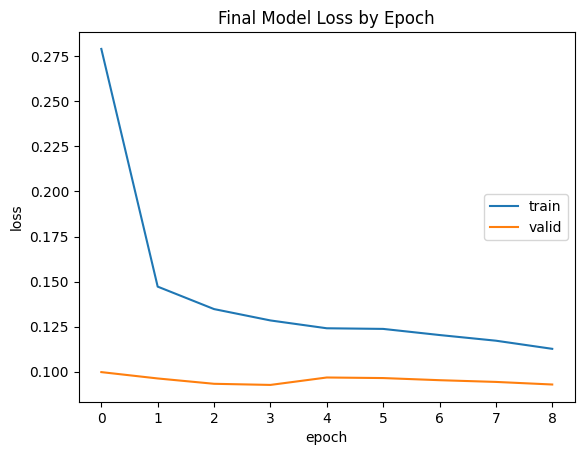

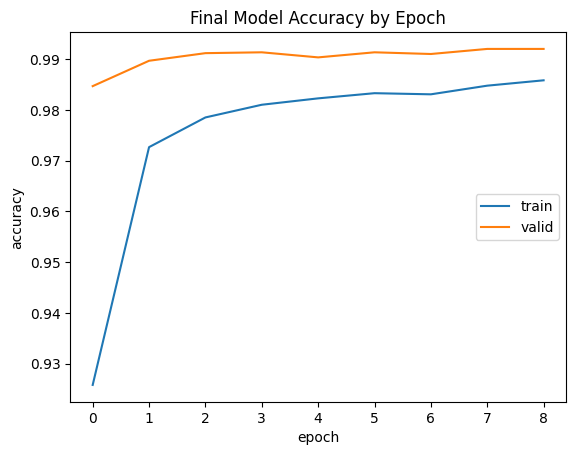


Training stopped at epoch: 9
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9908 - loss: 0.0963
The final loss on the TEST set is: 0.091.
The final compile_metrics on the TEST set is: 0.992.


In [15]:
# FINAL ASSIGNMENT: Combining both regularization techniques to achieve >99% accuracy on test set

import tensorflow.keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Optimized network parameters
batch_size = 32
num_epochs = 50  # Increased number of epochs
kernel_size = 5
pool_size = 2
conv_depth_1 = 32   # Increased number of filters
conv_depth_2 = 64   # Increased number of filters
drop_prob_1 = 0.25  # Dropout after pooling
drop_prob_2 = 0.5   # Dropout in FC layer
hidden_size = 128   # Increased hidden layer size
weight_penalty = 0.0001  # L2 regularization

# Build optimized model with both regularization techniques
model_final = Sequential()

# First Conv-Pool block
model_final.add( Conv2D(conv_depth_1, (kernel_size,kernel_size), padding='same', activation='relu',
                        data_format="channels_last", input_shape=(28, 28, 1),
                        kernel_regularizer=regularizers.l2(weight_penalty)) )
model_final.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model_final.add( Dropout(drop_prob_1) )

# Second Conv-Pool block
model_final.add( Conv2D(conv_depth_2, (kernel_size,kernel_size), padding='same', activation='relu',
                        kernel_regularizer=regularizers.l2(weight_penalty)) )
model_final.add( MaxPooling2D(pool_size=(pool_size, pool_size)) )
model_final.add( Dropout(drop_prob_1) )

# Fully connected layers
model_final.add( Flatten() )
model_final.add( Dense(hidden_size, activation='relu',
                       kernel_regularizer=regularizers.l2(weight_penalty)) )
model_final.add( Dropout(drop_prob_2) )
model_final.add( Dense(num_classes, activation='softmax') )

print(model_final.summary())

# Compile model
model_final.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train with reduced validation split for more training data
history_final = model_final.fit(X_train, Y_train,
                                batch_size=batch_size,
                                epochs=num_epochs,
                                verbose=1,
                                validation_split=0.1,  # Reduced from 0.7 to 0.1
                                callbacks=[early_stopping])

# Visualize training curves
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('Final Model Loss by Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

# Plot accuracy curves
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('Final Model Accuracy by Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

print(f'\nTraining stopped at epoch: {len(history_final.history["loss"])}')

# Evaluate on test set
for loss_name, loss_value in list(zip(model_final.metrics_names, model_final.evaluate(X_test, Y_test, verbose=1))):
    print('The final {} on the TEST set is: {:.3f}.'.format(loss_name, loss_value))


**OPTIONAL assignment:**
Test on your own examples: 1/ draw yourself by hand (for example in Microsoft Paint or equivalent image editor, or on paper that you photograph afterwards with your smartphone) a few examples for each class of handwritten digits; 2/ rescale and crop your images so that their size is 28x28 pixels with nearly no white borders around digits, and make sure they are saved as grayscale or even black-and-white; 3/ In the code cell below, load your images, plot them, and then feed each one into your best trained ConvNet and display for each one the class probabilities estimated by your ConvNet:

In [16]:
# OPTIONAL: Test on your own handwritten digits

from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

# Example code to load and test custom images
# Note: You need to create your own 28x28 grayscale images first

# Uncomment and modify the code below once you have your own images:

"""
# List of image file paths (replace with your actual file paths)
custom_image_paths = [
    'path/to/your/digit_0.png',
    'path/to/your/digit_1.png',
    'path/to/your/digit_2.png',
    # Add more image paths here...
]

# Function to load and preprocess a single image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, color_mode='grayscale', target_size=(28, 28))
    img_array = image.img_to_array(img)
    img_array = img_array.astype('float32') / 255.0
    img_array = img_array.reshape(1, 28, 28, 1)  # Reshape for the model
    return img_array, img

# Process and predict for each custom image
for img_path in custom_image_paths:
    img_array, original_img = load_and_preprocess_image(img_path)

    # Make prediction
    predictions = model_final.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]

    # Display the image and predictions
    plt.figure(figsize=(10, 3))

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f'Predicted: {predicted_class} (Confidence: {confidence:.2%})')
    plt.axis('off')

    # Show probability distribution
    plt.subplot(1, 2, 2)
    plt.bar(range(10), predictions[0])
    plt.xlabel('Digit Class')
    plt.ylabel('Probability')
    plt.title('Class Probabilities')
    plt.xticks(range(10))
    plt.ylim([0, 1])

    plt.tight_layout()
    plt.show()

    # Print detailed probabilities
    print(f'\nImage: {img_path}')
    print(f'Predicted class: {predicted_class}')
    print('Probabilities for each class:')
    for i, prob in enumerate(predictions[0]):
        print(f'  Digit {i}: {prob:.4f} ({prob*100:.2f}%)')
    print('-' * 50)
"""

print("To test your own handwritten digits:")
print("1. Create 28x28 grayscale images of handwritten digits")
print("2. Save them in an accessible directory")
print("3. Uncomment and modify the code above with your image paths")
print("4. Run the cell to see predictions!")


To test your own handwritten digits:
1. Create 28x28 grayscale images of handwritten digits
2. Save them in an accessible directory
3. Uncomment and modify the code above with your image paths
4. Run the cell to see predictions!
